<a href="https://colab.research.google.com/github/jimmyshah83/deep_learning/blob/master/GAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN Using Keras

In [0]:
#import tensorflow as tf
#tf.enable_eager_execution()

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function
#!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

In [0]:
import os
import time
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
import time

from tensorflow.keras import layers

%matplotlib inline

In [0]:
# Hyperparameters
IMAGE_SIZE = 64
NOISE_SIZE = 100
BATCH_SIZE = 128
BETA1 = 0.5
EPSILON = 0.00005
BUFFER_SIZE = 100
EPOCHS = 300

In [0]:
train_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) 
                           for file in glob('drive/My Drive/images/' + '*.png')])

In [147]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = train_images.astype('float32')
print ("Input: " + str(train_images.shape))

Input: (9877, 64, 64, 3)


In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8, 8, 1024)))
    assert model.output_shape == (None, 8, 8, 1024)
    
    model.add(layers.Conv2DTranspose(512, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(epsilon=EPSILON))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), padding='same', use_bias=False))
    
    return model

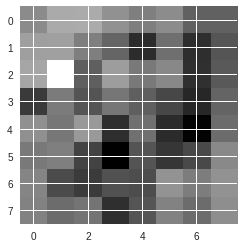

In [150]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv2D(32, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
  
  model.add(layers.Conv2D(64, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2D(128, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
    
  model.add(layers.Conv2D(256, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Conv2D(512, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Conv2D(1024, (5, 5), padding='same', strides=(2, 2)))
  model.add(layers.BatchNormalization(epsilon=EPSILON))
  model.add(layers.LeakyReLU())
              
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
              
  return model

In [152]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
decision.shape

tf.Tensor([[0.49999988]], shape=(1, 1), dtype=float32)


TensorShape([Dimension(1), Dimension(1)])

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer()
generator_optimizer = tf.train.AdamOptimizer()
seed = tf.random.normal([16, 100])

In [0]:
def generate_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot()
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

In [0]:
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, NOISE_SIZE])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(grads_and_vars=zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(grads_and_vars=zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    
    generate_images(generator, epoch + 1, seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [0]:
train(train_dataset, 300)